# Algorithm Walk-Through

This notebook will walkthrough the preprocessing steps as well as the ML algorithm training procedure used for the multi-dimensional, multi-output data. 

## Experiment Overview

## Code

### Packages

In [14]:
import sys
sys.path.insert(0, "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/src")

# Standard packages
import numpy as np
import pandas as pd

# Datasets
from data.make_dataset import DataLoader, load_standard_data, load_high_dim_data, load_labels

# Features
from features.build_features import times_2_cycles, geo_2_cartesian, get_geodataframe, CycleTransform, GeoCartTransform
from features.pca_features import transform_all, transform_individual
from features.analysis import get_stats
from sklearn.preprocessing import StandardScaler

# ML Models
from sklearn.model_selection import train_test_split
from models.baseline import train_rf_model

# Visualization
from visualization.visualize import plot_mo_stats, plot_geolocations
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
### 1 Load Data

#### 1.1 Core Data

In this step, we will load the standard data. This includes the following variables:

* SLA
* PAR
* RHO WN 412
* RHO WN 443
* RHO WN 490
* RHO WN 555
* RHO WN 670
* MLD
* Lat
* Lon
* DOY

In [110]:
X_core = load_standard_data('NA')

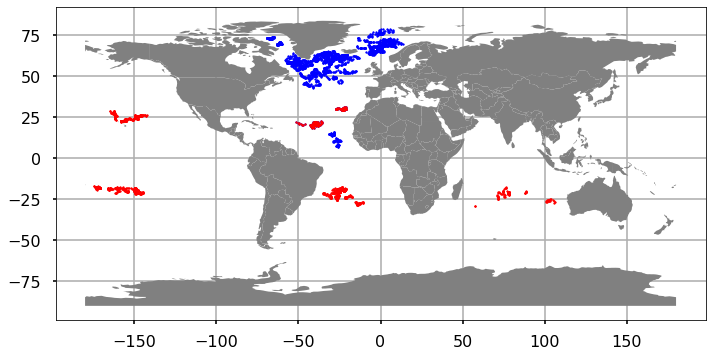

In [30]:
X_core_na = load_standard_data('NA')
X_core_stg = load_standard_data('STG')

# convert dataframe into geopandas dataframe
X_core_na_gdf = get_geodataframe(X_core_na.copy())
X_core_na_stg = get_geodataframe(X_core_stg.copy())

# plot world map with points
colors = ['blue', 'red']
plot_geolocations([X_core_na_gdf, X_core_na_stg], colors=['blue', 'red'], save_name='both')

#### 1.2 High Dimensional Data

In this section, we will extract the high dimensional datasets. They include:

* Temperature
* Density
* Salinity
* Spiciness

In [113]:
X_temp, X_dens, X_sal, X_spicy = load_high_dim_data('NA')

# add prefix
X_temp = X_temp.add_prefix('temp_')
X_dens = X_dens.add_prefix('dens_')
X_sal = X_sal.add_prefix('sal_')
X_spicy = X_spicy.add_prefix('spice_')

#### 1.3 - Multi-Output Data

We load the multioutput regression labels.

In [114]:
y = load_labels('NA')

---
### 3 - Train,Test Split

We split the data into 80% training and 20% training.

**Note**: because the dataset we are dealing with is only ~3,000 data points, we will do some bootstrap techniques in the full experiment to see how well we do with different subsamples of data.

In [115]:
Xdf = pd.concat([
    X_core, 
    X_temp, 
#     X_dens, 
    X_sal, 
    X_spicy
], axis=1)

Xtr, Xte, ytr, yte =  train_test_split(
        Xdf, y,
        train_size=0.8, random_state=123
    )

---
### 4 - Post-Split Transformations



1. PCA Transform High Dimensional Variables

In this step, we do a PCA transformation on the concatenation for the high dimensional variables `temp`, `sal`, `dens`, and `spicy`. We will reduce the dimensionality to about 10 features.

2. Normalize Core Variables

We will use a standard scaler to make the core variables with a mean of 0 and standard deviation of 1. The ML algorithms tend to perform better with this type of standardization.

3. Coordinate Transformation

In this step, we will do a simple coordinate transformation of the lat,lon variables from geospatial to cartesian coordinates. This will increase the dimensionality of our dataset from 11 dimensions to 12 dimensions.

4. Time Transformation

In this step, we will transform the `doy` coordinates to cycles of sines and cosines. This will increase the dimensionality of our data from from 12 to 13.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

In [116]:
# new columns columns
temp_columns = X_temp.columns.values
dens_columns = X_dens.columns.values
sal_columns = X_sal.columns.values
spicy_columns = X_spicy.columns.values
core_columns = ['sla', "PAR","RHO_WN_412","RHO_WN_443","RHO_WN_490","RHO_WN_555","RHO_WN_670","MLD"]
time_columns = ['doy']
loc_columns = ['lat', 'lon']

n_components = 5
times = ['doy']

new_columns = [
    *["doy_cos", "doy_sin"], 
    *['x', 'y', 'z',],
    *[f"temperature_pc{icomponent+1}" for icomponent in range(n_components)],
#     *[f"density_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"salinity_pc{icomponent+1}" for icomponent in range(n_components)],
    *[f"spicy_pc{icomponent+1}" for icomponent in range(n_components)],
    *core_columns, 
]
seed = 123

# define transfomer
X_transformer = ColumnTransformer(
    [   ("time", CycleTransform(times), time_columns),
        ("space", GeoCartTransform(), loc_columns),
        ('temp', PCA(n_components=n_components, random_state=seed), temp_columns),
#         ('dens', PCA(n_components=n_components, random_state=seed), dens_columns),
        ('sal', PCA(n_components=n_components, random_state=seed), sal_columns),
        ('spice', PCA(n_components=n_components, random_state=seed), spicy_columns),
        ('core', StandardScaler(with_mean=True, with_std=True), core_columns)
    ],
    remainder='passthrough'
)
# fit transform to data
X_transformer.fit(Xtr)

# transform data
Xtrain = X_transformer.transform(Xtr)
Xtest = X_transformer.transform(Xte)

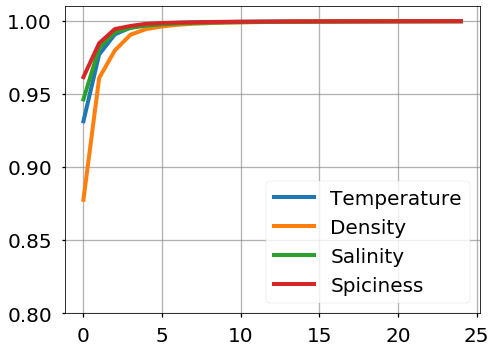

In [91]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'na'
# y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(X_transformer.named_transformers_['temp'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Temperature')
plt.plot(X_transformer.named_transformers_['dens'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Density')
plt.plot(X_transformer.named_transformers_['sal'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Salinity')
plt.plot(X_transformer.named_transformers_['spice'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Spiciness')
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
ax.set_ylim([0.8, 1.01])
plt.legend(fontsize=20, loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig(SAVE_PATH + f"evar_{save_name}.png")

#### 2.3 - Output Log Transformation

The distribution of the outputs are skewed because there is a lot more variability in the upper depths than the lower depths. Because the distribution of the outputs are fairly skewed, we propose to do a log transformation to make them normally distributed.

In [117]:
ytr_log = np.log(ytr)
yte_log = np.log(yte)

#### 4.3 - Normalize Outputs

We will use the same standardization as shown above.

In [118]:
output_transformer = StandardScaler(with_mean=True, with_std=False)

ytrain = output_transformer.fit_transform(ytr_log)
ytest = output_transformer.transform(yte_log)

---
### 5 - Train ML Model

In this section, we will use a standard random forest (RF) regressor to train on our dataset. Because our data is multi-output, we will need 1 RF per output layer.

In [137]:
rf_model = train_rf_model(Xtrain, ytrain[:, 0], verbose=0)

---
### 6 - Test ML Model

#### 6.1 - Training Data Results

This is often not reported but it is very good to check how well a model does on the initial training data because we have no entered a validation set. If we find that the training stats are too high and the testing stats are very low then we know that we're either overfitting and/or our model is not generalizing very well.

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_stats(y_pred: np.ndarray, y: np.ndarray, each_level: bool=False):
    
    stats = pd.DataFrame()
    
    # Get total average statistics
    if each_level == False:
        multioutput = 'uniform_average'
        mae = mean_absolute_error(y, ypred, multioutput=multioutput)
        mse = mean_squared_error(y, ypred, multioutput=multioutput)
        rmse = mse
        r2 = r2_score(y, ypred, multioutput=multioutput)
        stats = pd.DataFrame(data=[[mae, mse, rmse, r2]], columns=['mae', 'mse', 'rmse', 'r2'])
    elif each_level == True:
        multioutput = 'raw_values'
        stats['mae'] = mean_absolute_error(y, ypred, multioutput=multioutput)
        stats['mse'] = mean_squared_error(y, ypred, multioutput=multioutput)
        stats['rmse'] = np.sqrt(stats['mse'])
        stats['r2'] = r2_score(y, ypred, multioutput=multioutput)
    else:
        raise ValueError(f"Unrecognized stat request: {each_level}")
    
    return stats

First we will look at the statistics on average to see what we get.

In [120]:
ypred = rf_model.predict(Xtrain)

In [121]:
# each level
each_level = False

stats = get_stats(ypred, ytrain, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.052106,0.006352,0.006352,0.963141


Then we can look at the statistics for each level.

In [122]:
each_level = True

stats_df = get_stats(ypred, ytrain, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.096865,0.018830,0.137222,0.969033
1,0.095829,0.018564,0.136249,0.969969
2,0.096502,0.019033,0.137959,0.969814
3,0.096949,0.019117,0.138265,0.970135
4,0.097076,0.019358,0.139134,0.969777


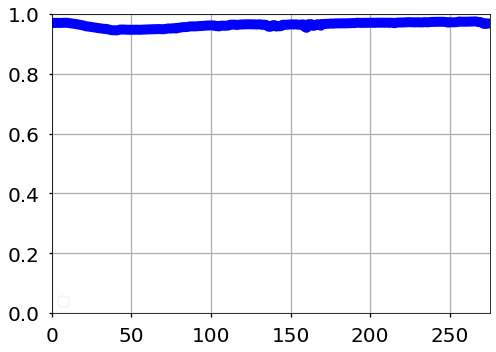

In [123]:
statistic = 'r2'

plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat=statistic, 
    save_name='na_train'
)

#### 6.2 - Testing Data Results

In [138]:
ypred = rf_model.predict(Xtest)

In [140]:
# each level
each_level = False

stats = get_stats(ypred, ytest[:, 0], each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.277807,0.149056,0.149056,0.733938


In [126]:
each_level = True

stats_df = get_stats(ypred, ytest, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.278298,0.150482,0.387920,0.731392
1,0.275361,0.147978,0.384679,0.739083
2,0.278303,0.152700,0.390769,0.735527
3,0.277453,0.151686,0.389469,0.740118
4,0.280141,0.154537,0.393111,0.737845


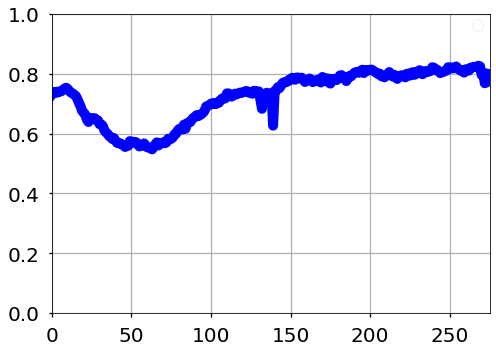

In [127]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat='r2', 
    save_name='na_test'
)


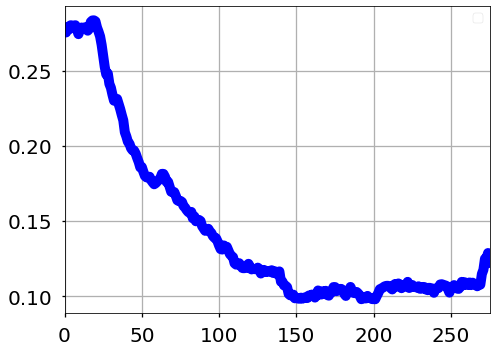

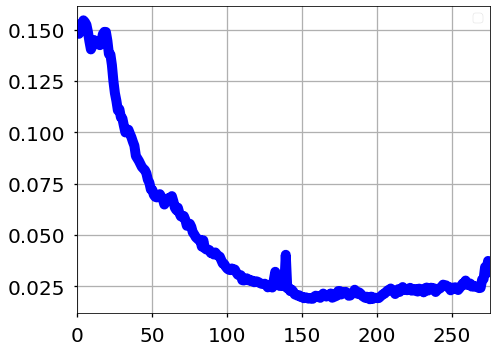

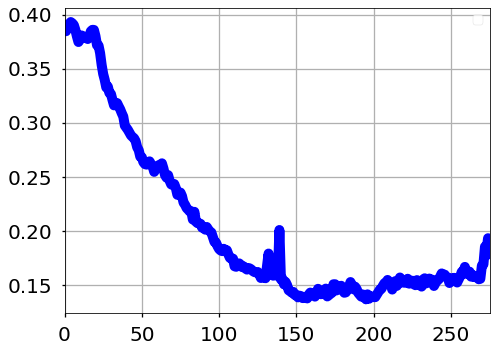

In [128]:
plot_mo_stats(stats_df, stat='mae', save_name='na_test')
plot_mo_stats(stats_df, stat='mse', save_name='na_test')
plot_mo_stats(stats_df, stat='rmse', save_name='na_test')

---
### 7 - Post Analysis

#### 7.1 - Feature Importance

For some algorithms, we can calculate the feature importance based on the inputs dimensions. This is true for the random forest model.

In [135]:
rf_model.

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [141]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

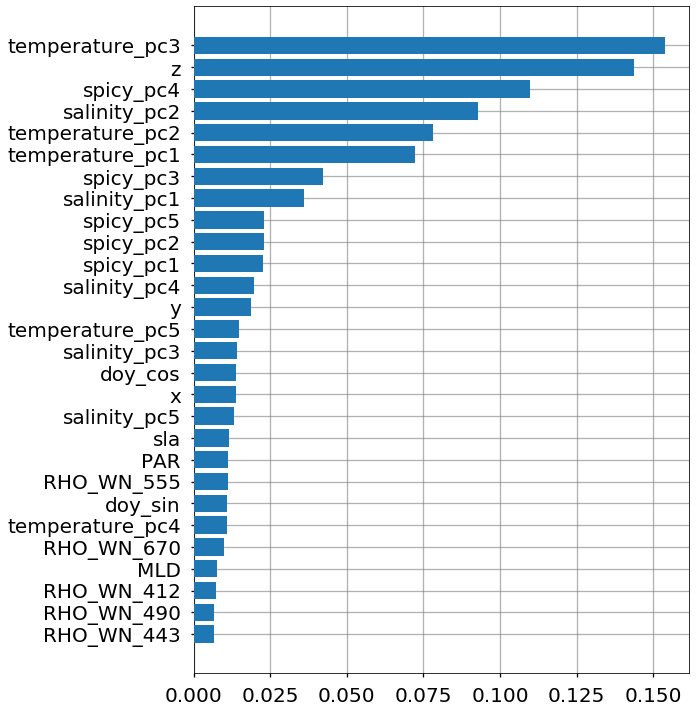

In [142]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'na'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
# fig.savefig(SAVE_PATH + f"fi_{save_name}.png")

#### 7.2 - Permutation Plot

In [179]:
perm_result_test = permutation_importance(
    rf_model, 
    Xtest, 
    ytest, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    0.7s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

In [36]:
sorted_idx = perm_result_test.importances_mean.argsort()

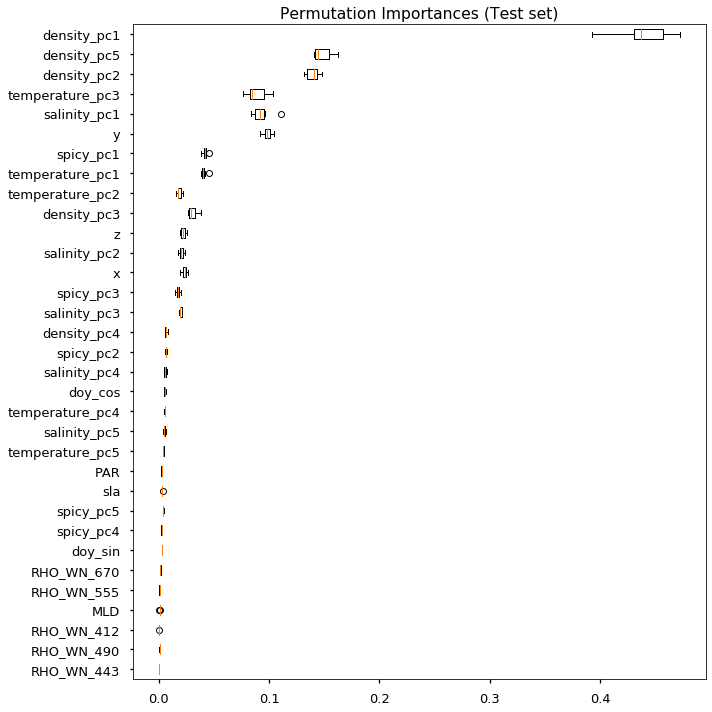

In [182]:
fig, ax = plt.subplots(figsize=(10,10))
plt.style.use(['seaborn-talk'])
ax.boxplot(
    perm_result_test.importances[sorted_idx].T,
    vert=False, 
    labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Test set)")
fig.tight_layout()
plt.show()

In [38]:
perm_result_train = permutation_importance(
    rf_model, 
    Xtrain, 
    ytrain, 
    n_repeats=10,
    random_state=42, 
    n_jobs=1
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 1500 out of 1500 | elapsed:    2.3s finished
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", Futu

KeyboardInterrupt: 

In [ ]:
sorted_idx = perm_result_train.importances_mean.argsort()

In [ ]:
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots()
ax.boxplot(
    perm_result_train.importances[sorted_idx].T,
    vert=False, 
    labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (Train set)")
fig.tight_layout()
plt.show()

## Subtropical Gyros

#### Load Data

In [92]:
X_core = load_standard_data('STG')

X_temp, X_dens, X_sal, X_spicy = load_high_dim_data('STG')

# add prefix
X_temp = X_temp.add_prefix('temp_')
X_dens = X_dens.add_prefix('dens_')
X_sal = X_sal.add_prefix('sal_')
X_spicy = X_spicy.add_prefix('spice_')

# Labels
y = load_labels('STG')

#### Train-Test Split

In [93]:
Xdf = pd.concat([X_core, X_temp, X_dens, X_sal, X_spicy], axis=1)

Xtr, Xte, ytr, yte =  train_test_split(
        Xdf, y,
        train_size=0.8, random_state=123
    )

#### Post Transformations

In [94]:
# new columns columns
temp_columns = X_temp.columns.values
dens_columns = X_dens.columns.values
sal_columns = X_sal.columns.values
spicy_columns = X_spicy.columns.values
core_columns = ['sla', "PAR","RHO_WN_412","RHO_WN_443","RHO_WN_490","RHO_WN_555","RHO_WN_670","MLD"]
time_columns = ['doy']
loc_columns = ['lat', 'lon']

n_components = None
times = ['doy']

# new_columns = [
#     *["doy_cos", "doy_sin"], 
#     *['x', 'y', 'z',],
#     *[f"temperature_pc{icomponent+1}" for icomponent in range(n_components)],
#     *[f"density_pc{icomponent+1}" for icomponent in range(n_components)],
#     *[f"salinity_pc{icomponent+1}" for icomponent in range(n_components)],
#     *[f"spicy_pc{icomponent+1}" for icomponent in range(n_components)],
#     *core_columns, 
# ]
seed = 123
# define transfomer
X_transformer = ColumnTransformer(
    [   ("time", CycleTransform(times), time_columns),
        ("space", GeoCartTransform(), loc_columns),
        ('temp', PCA(n_components=n_components, random_state=seed), temp_columns),
        ('dens', PCA(n_components=n_components, random_state=seed), dens_columns),
        ('sal', PCA(n_components=n_components, random_state=seed), sal_columns),
        ('spice', PCA(n_components=n_components, random_state=seed), spicy_columns),
        ('core', StandardScaler(with_mean=True, with_std=True), core_columns)
    ],
    remainder='passthrough'
)
# fit transform to data
X_transformer.fit(Xtr)

# transform data
Xtrain = X_transformer.transform(Xtr)
Xtest = X_transformer.transform(Xte)

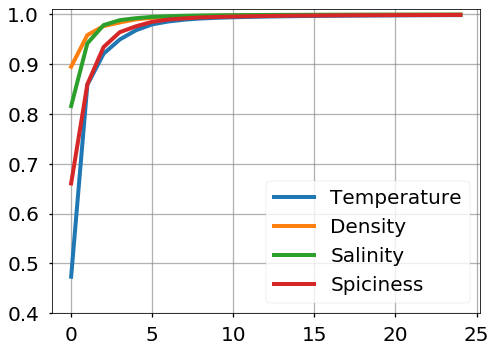

In [95]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'stg'
# y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(X_transformer.named_transformers_['temp'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Temperature')
plt.plot(X_transformer.named_transformers_['dens'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Density')
plt.plot(X_transformer.named_transformers_['sal'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Salinity')
plt.plot(X_transformer.named_transformers_['spice'].explained_variance_ratio_[:25].cumsum(), linewidth=4, label='Spiciness')
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
ax.set_ylim([0.4, 1.01])
plt.legend(fontsize=20, loc='lower right')
plt.tight_layout()
plt.show()
fig.savefig(SAVE_PATH + f"evar_{save_name}.png")

In [10]:
ytr_log = np.log(ytr)
yte_log = np.log(yte)

output_transformer = StandardScaler(with_mean=True, with_std=False)

ytrain = output_transformer.fit_transform(ytr_log)
ytest = output_transformer.transform(yte_log)

#### Train ML Model

In [11]:
rf_model = train_rf_model(Xtrain, ytrain, verbose=0)

#### Test ML Model

In [17]:
ypred = rf_model.predict(Xtest)
# each level
each_level = False

stats = get_stats(ypred, ytest, each_level=each_level)

stats

,mae,mse,rmse,r2
0,0.076012,0.011566,0.011566,0.836507


In [18]:
each_level = True

stats_df = get_stats(ypred, ytest, each_level=each_level)

stats_df.head()

,mae,mse,rmse,r2
0,0.090821,0.015937,0.126243,0.796359
1,0.079254,0.013080,0.114367,0.831335
2,0.080978,0.013442,0.115940,0.819716
3,0.081550,0.013506,0.116216,0.813086
4,0.076334,0.011775,0.108515,0.826654


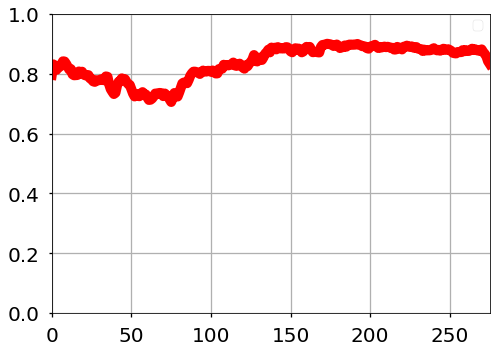

In [24]:
statistic = 'r2'
plt.style.use('seaborn-talk')
plot_mo_stats(
    stats_df, 
    stat='r2', 
    save_name='stg_test',
    color='red'
)

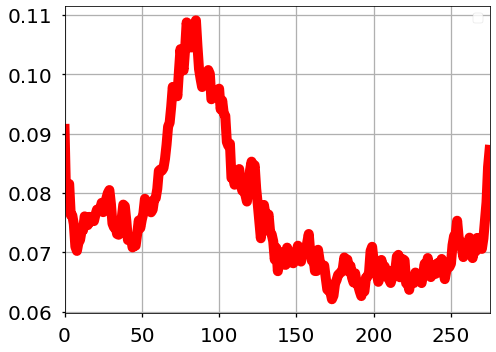

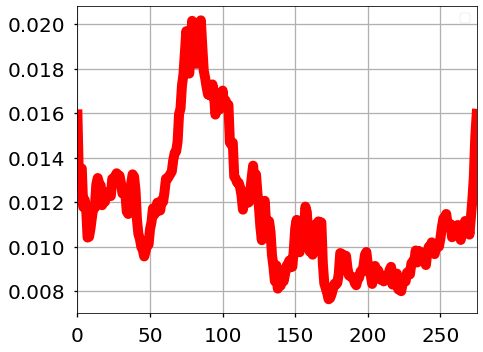

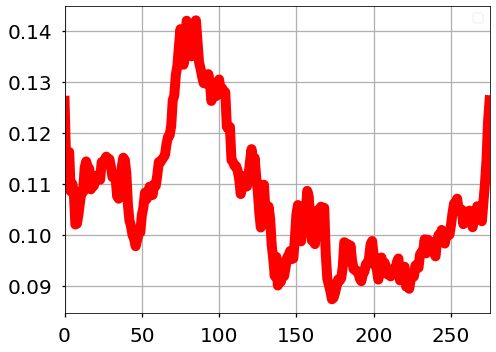

In [25]:
plot_mo_stats(stats_df, stat='mae', save_name='stg_test', color='red')
plot_mo_stats(stats_df, stat='mse', save_name='stg_test', color='red')
plot_mo_stats(stats_df, stat='rmse', save_name='stg_test', color='red')

#### Post Analysis

In [22]:
tree_feature_importances = \
    rf_model.feature_importances_

feature_names = np.asarray(new_columns) #np.concatenate((core_columns.values, np.array(pca_columns)))

assert feature_names.shape[0] == tree_feature_importances.shape[0], "Shapes don't match"

sorted_idx = tree_feature_importances.argsort()

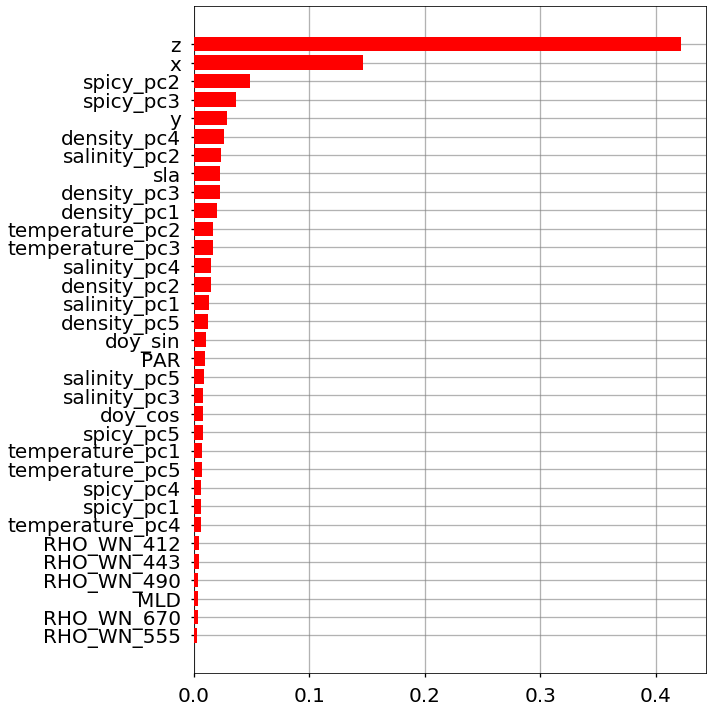

In [26]:
SAVE_PATH = "/media/disk/erc/papers/2019_ML_OCN/ml4ocean/reports/figures/"
save_name = 'stg'
y_ticks = np.arange(0, len(feature_names))
plt.style.use(['seaborn-talk'])
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks, tree_feature_importances[sorted_idx], zorder=3, height=0.8, color='red')
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
ax.tick_params(axis="both", which="major", labelsize=20)
ax.tick_params(axis="both", which="minor", labelsize=20)
ax.grid(alpha=0.6, color='gray', zorder=0)
plt.tight_layout()
plt.show()
fig.savefig(SAVE_PATH + f"fi_{save_name}.png")

In [105]:
depths = 276
first = [*range(1, 250)]
d1 = first[::2]

second = [*range(251,1000)]
d2 = second[::5]


In [106]:
len(d1), len(d2)

(125, 150)

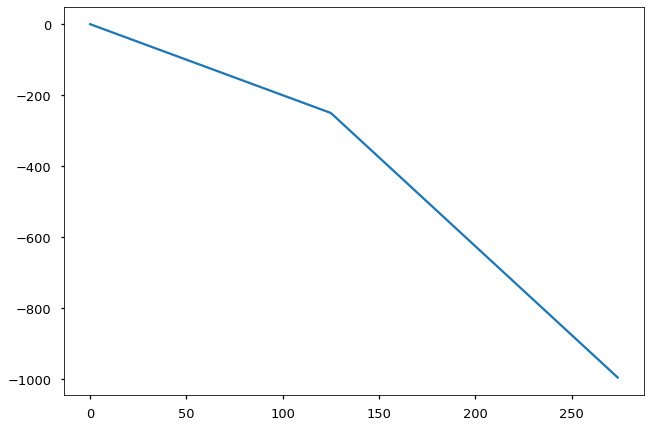

In [109]:
plt.plot(-np.concatenate((d1,d2)))